<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [100]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [101]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [102]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [103]:
model = tf.keras.Sequential()

drop_out = 0.4
lern_rat = 0.00001
neurons = 5000

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
# model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))

# model.add(layers.Dense(216, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [104]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [105]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=1024,
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/20
49/49 [==============================] - 10s 164ms/step - loss: 4.7836 - sparse_categorical_accuracy: 0.1425 - val_loss: 1.6808 - val_sparse_categorical_accuracy: 0.3894
Epoch 2/20
49/49 [==============================] - 8s 165ms/step - loss: 1.3576 - sparse_categorical_accuracy: 0.4942 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.6735
Epoch 3/20
49/49 [==============================] - 8s 163ms/step - loss: 0.8874 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.6895 - val_sparse_categorical_accuracy: 0.8026
Epoch 4/20
49/49 [==============================] - 8s 168ms/step - loss: 0.7194 - sparse_categorical_accuracy: 0.7967 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.8292
Epoch 5/20
49/49 [==============================] - 8s 169ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.8215 - val_loss: 0.5950 - val_sparse_categorical_accuracy: 0.8366
Epoch 6/20
49/49 [==============================] - 8s 166ms/step - loss: 0.6092 - sparse_categoric

In [106]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


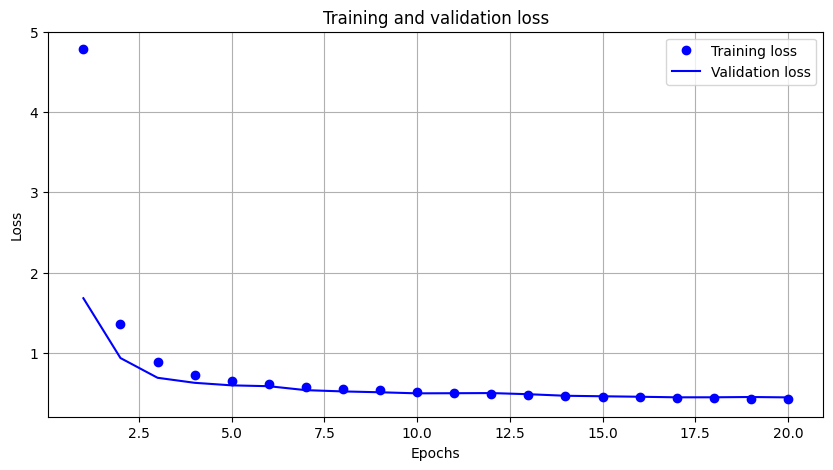

<Figure size 640x480 with 0 Axes>

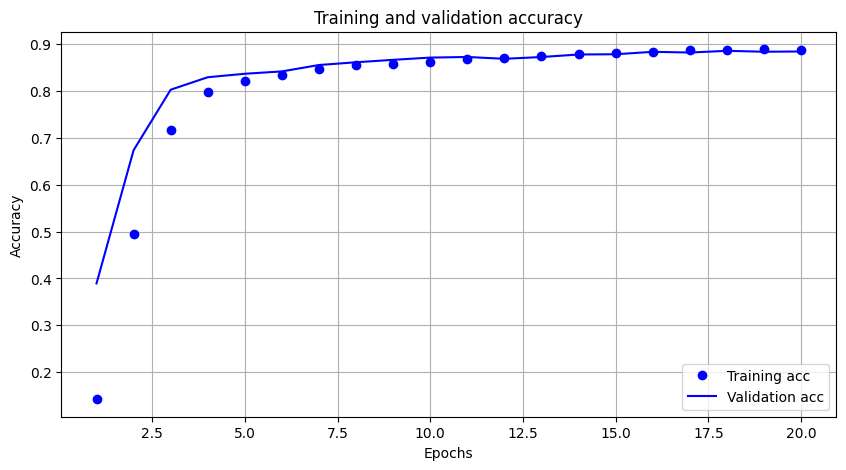

In [107]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [108]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [109]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [110]:
predictions[0]

array([0.08546155, 0.0854617 , 0.0854605 , 0.0854616 , 0.08546077,
       0.08554827, 0.08546057, 0.08619439, 0.08548928, 0.23000136],
      dtype=float32)

In [111]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 5000)              3925000   
                                                                 
 dropout_30 (Dropout)        (None, 5000)              0         
                                                                 
 dense_39 (Dense)            (None, 5000)              25005000  
                                                                 
 dropout_31 (Dropout)        (None, 5000)              0         
                                                                 
 dense_40 (Dense)            (None, 5000)              25005000  
                                                                 
 dropout_32 (Dropout)        (None, 5000)            